<a href="https://colab.research.google.com/github/3lueLightning/tutorials/blob/main/rag_development_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q langchain langchain_community tiktoken langchain_openai \
langchain_text_splitters docarray langsmith langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

# Loading the data
For this example we will be extracting the a list of the top 100 best movies of all time according to the magazin Empire. Let me know in the comments if you agree with the list ;)

In [3]:
import os
from langchain_community.document_loaders import WebBaseLoader

# to improve our chances of not being blocked online we set a user agent to
# out crawler. This means
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"


## Test connection

Testing that we can access the page with a simple HTTP request (working as a combination of `request.get` and `bs4.BeautifulSoup`), more info [here](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)

In [4]:
MOVIES_URL = "https://www.empireonline.com/movies/features/best-movies-2/"

full_page = WebBaseLoader(MOVIES_URL).load()
if not full_page:
  print("The page didn't load, but no worries we have a backup ;)")
else:
  print(full_page[0].page_content[:200])

The 100 Best Movies Of All Time | Movies | %%channel_name%% MoviesReviewsNewsFeaturesTVGamingPodcastsEmpire VIPShoppingEmpire MagazineSubscribeManage My SubscriptionNewsletterHome|Movies|FeaturesThe 1


## Get data

SoupStainers allow us to extract information from a html without have to load everything in memory and then doing a find_all making it a more efficient option, more info [here](https://medium.com/codex/using-beautiful-soups-soupstrainer-to-save-time-and-memory-when-web-scraping-ea1dbd2e886f)

In [5]:
from bs4 import SoupStrainer


def is_target_element(elem, attrs):
    # get the movie description
    div_class = "listicleItem_listicle-item__content__Lxn1Y"
    div_mask = (elem == "div" and attrs.get("class") == div_class)
    # get the movie title
    h3_class = "listicleItem_listicle-item__title__BfenH"
    h3_mask = (elem == "h3" and attrs.get("class") == h3_class)
    return div_mask or h3_mask

strainer = SoupStrainer(is_target_element)


movie_scraper = WebBaseLoader(
    "https://yvy",#MOVIES_URL,
    bs_kwargs = {
        "parse_only": strainer
    }
)

try:
  movie_reviews_raw = movie_scraper.load()
except:
  movie_reviews_raw = []

In [6]:
if (
    not movie_reviews_raw
    or movie_reviews_raw[0].page_content != "100 Reservoir Dogs\nMaking"
):
  import pickle
  import urllib
  BACKUP_MOVIES_PKL_URL = "https://tutorials-public.s3.eu-west-1.amazonaws.com/movie_reviews_raw.pkl"
  with urllib.request.urlopen(BACKUP_MOVIES_PKL_URL) as response:
      movie_reviews_raw = pickle.load(response)
  print("loaded list of top 10 best movies from backup system")
else:
  print("successfully scrapped list of top 10 best movies")

loaded list of top 10 best movies from backup system


# Process data

All the movie reviews come as a single document, but we want to split them and remove the links to the full movie reviews at the end of each block

In [7]:
import re
from langchain.docstore.document import Document


def split_movies(page: Document) -> list[Document]:
  page_parts = page.page_content.strip().split("\n")
  names_n_reviews = [elem for elem in page_parts if not elem.startswith("Read")]
  movie_names = [re.sub(r'^\d*\)? ', "", name) for name in names_n_reviews[::2]]
  movie_reviews = [
      f"{name}: {description}"
      for name, description in zip(movie_names, names_n_reviews[1::2])
  ]
  movie_docs = [
      Document(review, metadata={**page.metadata, "rank": i, "name": name})
      for review, i, name in zip(movie_reviews, range(100, 0, -1), movie_names)
  ]
  return movie_docs

In [8]:
movie_reviews = split_movies(movie_reviews_raw[0])
print(f"extracted {len(movie_reviews)}")
movie_reviews[0]

extracted 100


Document(page_content="Reservoir Dogs: Making his uber cool and supremely confident directorial debut, Quentin Tarantino hit audiences with a terrific twist on the heist-gone-wrong thriller. For the most part a single location chamber piece, Reservoir Dogs delights in ricocheting the zing and fizz of its dialogue around its gloriously —and indeed gore-iously) — intense setting, with the majority of the movie's action centring around one long and incredibly bloody death scene. Packing killer lines, killer needledrops, and killer, er, killers too, not only is this a rollicking ride in its own right, but it also set the blueprint for everything we've come to expect from a Tarantino joint. Oh, and by the way: Nice Guy Eddie was shot by Mr. White. Who fired twice. Case closed.", metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 100, 'name': 'Reservoir Dogs'})

## Data Analysis
Let's check there are any issues with the data and understand how much we will be charged by OpenAI taking into account that we are charge by token sent to their API. There way of tokenizing the by OpenAI is via tiktoken.


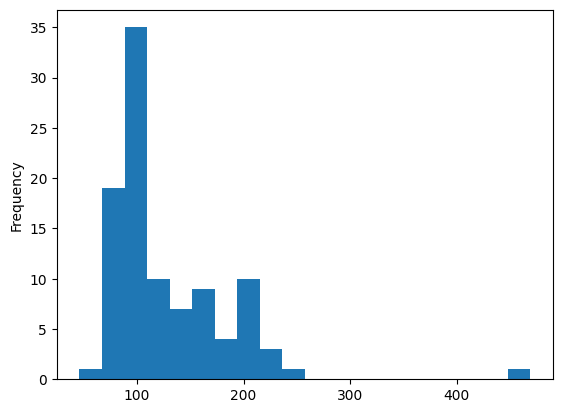

In [9]:
import tiktoken
import pandas as pd


def count_tokens(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_counts = pd.Series(movie_reviews).apply(
    lambda doc: count_tokens(doc.page_content, "cl100k_base")
)
token_counts.plot.hist(bins=20);

We notice that there is one movie with a lot more tokens then the other. So we check that there are no issues.

In [10]:
import numpy as np

movie_reviews[np.argmax(token_counts)].page_content

"The Lord Of The Rings: The Fellowship Of The Ring: A wizard is never late. Nor is he early. He arrives precisely when he... well, you know the rest. It might have taken 20 years for Peter Jackson's plucky fantasy to clamber, Mount-Doom-style, to the very pinnacle of our greatest-movies pantheon. But here it is, brighter and more resplendent than ever.The Fellowship Of The Ring contains so much movie. Even at the halfway point, as the characters take a breather to bicker in Rivendell, you already feel sated, like you've experienced more thrills, more suspense, more jollity and ethereal beauty than a regular film could possibly muster up. But Jackson is only getting started. Onwards his adventure hustles, to the bravura dungeoneering of Khazad-dum, to the sinisterly serene glades of Lothlorien, to the final requiem for flawed Boromir amidst autumnal leaves. As Fellowship thrums to its conclusion, finally applying the brakes with a last swell of Howard Shore's heavenly score, you're left

# Set up database

## Embedding
Creating an embedding using Open API's models, more infor [here](https://platform.openai.com/docs/guides/embeddings)

In [11]:
import getpass
OPENAI_API_KEY = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

··········


In [12]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL_NAME = "text-embedding-3-large"

embeder = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# testing embeding
test_embedding = embeder.embed_query("What is 'Hello World'?")
print(test_embedding[:5])
print(f"the model {EMBEDDING_MODEL_NAME} generates embeddings of length: {len(test_embedding)}")

[-0.015843020752072334, -0.056327491998672485, -0.014403410255908966, 0.01967223733663559, -0.017874551936984062]
the model text-embedding-3-large generates embeddings of length: 3072


## Insertion in Index

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
# docarray was imported earlier to avoid an error when using from_documents()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    length_function=len,
)

text_splitter.split_text(movie_reviews[5].page_content)

["Donnie Darko: A high school drama with a time traveling, tangential universe threading, sinister rabbit featuring twist, Richard Kelly's deliberately labyrinthine opus was always destined for cult classic status. A certifiable flop upon its theatrical release, Kelly's film was one of the early beneficiaries of physical media's move to DVD, with the movie gaining a fandom in film obsessives who could pause, play, and skip back and forth through it at will. Any attempt to synopsise the movie is a fool's errand, but there's more than a hint of\xa0It's A Wonderful Life in the way we see Donnie (Jake Gyllenhaal, in a star-making turn) experiencing how the world would be worse off if he survives the jet engine that mysteriously crashes through his bedroom. That the film, with all its heavy themes and brooding atmosphere, manages to eventually land on a note of overwhelming optimism is a testament to Kelly's mercurial moviemaking. A mad world (mad world) Donnie Darko's may be, but it's also

In [14]:
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch


index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeder,
    text_splitter=text_splitter,
).from_documents(movie_reviews)

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [15]:
QUESTION = "Can you recommend me an adventure movie?"

retriever = index.vectorstore.as_retriever()
relevant_movies = retriever.vectorstore.similarity_search(
    QUESTION,
    k=3 # by default k=4
)
for doc in relevant_movies:
  print(doc.page_content)

Indiana Jones And The Last Crusade: You voted... wisely. There may only be 12 years' difference between Harrison Ford and Sean Connery, but it's hard to imagine two better actors to play a bickering father and son, off on a globetrotting, Nazi-bashing, mythical mystery tour. After all, you've got Spielberg/Lucas' own version of James Bond... And the original Bond himself.
Raiders Of The Lost Ark: In '81, it must have sounded like the ultimate pitch: the creator of Star Wars teams up with the director of Jaws to make a rip-roaring, Bond-style adventure starring the guy who played Han Solo, in which the bad guys are the evillest ever (the Nazis) and the MacGuffin is a big, gold box which unleashes the power of God. It still sounds like the ultimate pitch.
Lawrence Of Arabia: If you only ever see one David Lean movie... well, don't. Watch as many as you can. But if you really insist on only seeing one David Lean movie, then make sure it's Lawrence Of Arabia, the movie that put both the "s

As you can see the embeddings worked properly as we have succesfully extracted 3 adventure movies.

# LLM

In [16]:
from langchain_openai import ChatOpenAI


LLM_MODEL_NAME = "gpt-3.5-turbo"
llm = ChatOpenAI(
    model=LLM_MODEL_NAME,
    # higher temperature means more orginal answers so we set it to the max
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# testing that the LLM works
llm.invoke("Hey how are you GPTie?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to assist you. How can I help you today?", response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 15, 'total_tokens': 46}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-153ebd54-cf18-4662-822d-e104ba1306fd-0', usage_metadata={'input_tokens': 15, 'output_tokens': 31, 'total_tokens': 46})

Now we will use the prompt template created via LangChain Hub in [here](https://smith.langchain.com/hub/blue-lightning/movie-advisor). To create a prompt yourself you must log-in via LangSmith.

Note that many other tutorials use `ChatPromptTemplate` instead, that is also fine, but it means that you have to store your templates in the code itself and it's not so easy to visualise or test. In addition it means you have to remember to git commit each time you tests a new prompt in order to be able to revert to it if needed. Finally it doesn't allow you to keep track of the performance of each promtp naturally - more on this in the next tutorial.

In [17]:
from langchain import hub


chat_template = hub.pull("blue-lightning/movie-advisor")
chat_template

ChatPromptTemplate(input_variables=['context', 'input'], metadata={'lc_hub_owner': 'blue-lightning', 'lc_hub_repo': 'movie-advisor', 'lc_hub_commit_hash': 'c3f49564c55f02454221604292cc7fd1c8e1ba567f0e5d6719aa2b0892d5b1af'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='When asked a question reply as if you were the wizard of movies with the knowledge about movies. Try to be funny were possible but base you answers in the information provided in the context section.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'input'], template='User question:\n{input}\n\n-----------------------------------------\nContext:\n{context}'))])

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain


combine_docs_chain = create_stuff_documents_chain(llm, chat_template)
# you can print combine_docs_chain to the how the chain was built, it is in
# LCEL (Lanchain expression language) which is beyond the scope of the tutorial

In [ ]:
from langchain.chains import create_retrieval_chain


chat_chain = create_retrieval_chain(retriever, combine_docs_chain)

In [18]:
try:
  # this is when your request actually goes to your LLM in this case the OpenAI servers
  chat_answer = chat_chain.invoke({"question": QUESTION})
except KeyError as e:
  # gracefully handling the error. Note that the full trace was omitted because
  # it's not very informative unless you know LCEL
  print(f"KeyError: {e}")

Traceback (most recent call last):
  File "<ipython-input-18-3cb4ab7ff88d>", line 8, in <cell line: 7>
    chat_answer = chat_chain.invoke({"question": QUESTION})
  File "/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/base.py", line 4588, in invoke
    return self.bound.invoke(
  File "/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/base.py", line 2505, in invoke
    input = step.invoke(input, config, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/passthrough.py", line 469, in invoke
    return self._call_with_config(self._invoke, input, config, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/base.py", line 1599, in _call_with_config
    context.run(
  File "/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/config.py", line 380, in call_func_with_variable_args
    return func(input, **kwargs)  # type: ignore[call-arg]
  File "/usr/local/lib/python3.10/dist-packages/l

This error was caused on purpose to hammer home that the variables in your prompt must be:
1. `context`: to provide the results of the retriever in `create_stuff_documents_chain`
2. `input`: to provide the user question in  `create_retrieval_chain`

In [31]:
from langchain.callbacks.tracers import ConsoleCallbackHandler

# you can replace ConsoleCallbackHandler by FileCallbackHandler if you wish to
# save the trace to file. A better option still is to save it to LangSmith
# but check the next tutorial for more on this ;)

chat_answer = chat_chain.invoke({"input": QUESTION}, config={'callbacks': [ConsoleCallbackHandler()]})


# the code bellow is equivalent to the above but gives you less control
# Plus as Uncle Bob once said (and I paraphrase): "people are terrible at
# doing things that come in pairs", so it is likely that any of us will forget
# to revert the debug to False. This is most useful if you want to debug every chain
#
# import langchain
#
# langchain.debug = True
# chat_answer = chat_chain.invoke({"input": QUESTION})
# langchain.debug = False

[chain/start] [chain:retrieval_chain] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context>] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context>] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context> > chain:retrieve_documents] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context> > chain:retrieve_documents > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/error] [chain:retrieval_chain > chai

KeyError: 'input'

In [19]:
from pprint import pprint


adventure_movies = chat_chain.invoke({"input": QUESTION})
# we use pprint rather then simply print to have all the text fit the screen
pprint(adventure_movies["answer"])

('As the wizard of movies, I shall grant you the recommendation you seek! For '
 'a thrilling adventure movie, I bestow upon you the epic journey of "The Lord '
 'of the Rings" trilogy. Watch as Frodo Baggins embarks on a perilous quest to '
 'destroy the One Ring and save Middle-earth from the clutches of the dark '
 'lord Sauron. Filled with breathtaking landscapes, heart-pounding battles, '
 'and memorable characters, this adventure will have you on the edge of your '
 'seat from start to finish. So, grab your sword, summon your courage, and '
 'prepare for an unforgettable cinematic adventure!')


We can try with another more complicated question who's answer requires a bit more thinking. Yet after a quick inspection of each movie we can see it is indeed a surrealist movie. Oviously this answers are not deterministic and you can have different ones, but I obtained: Pan's Labyrinth, Amelie, Vertigo and Mulholland Drive.

In [20]:
surrealist_movies = chat_chain.invoke({"input": "Which surrealist movies should I watch ?"})
for key, val in surrealist_movies.items():
  print(10 * "-" + f" {key} " + 10 * "-")
  pprint(val)

---------- input ----------
'Which surrealist movies should I watch ?'
---------- context ----------
[Document(page_content="Pan's Labyrinth: Guillermo Del Toro's fairy tale for grown-ups, as pull-no-punches brutal as it is gorgeously, baroquely fantastical. There's an earthy, primal feel to his fairy-world here, alien and threatening rather than gasp-inducing and 'magical', thanks in no small part to the truly cheese-dream nightmarish demon-things Del Toro conjures up, sans CGI, with the assistance of performer Doug Jones.", metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 61, 'name': "Pan's Labyrinth"}),
 Document(page_content="Amelie: Jean-Pierre Jeunet's fourth feature – his second as a solo artist divorced from Marc Caro – saw the\xa0Delicatessen,\xa0The City of Lost Children\xa0and\xa0Alien: Resurrection filmmaker leave behind the overwhelming darkness of his earlier works and step out into the glorious sunshine of Amelie's whimsical fant

As you can see in the 2nd question, we displayed not only the answer as previously but also the input (original question) and context (the result from the RAG). This allows us to verify that indeed that right question was fed to the model and that the context retreived ffrom our vector DB is not only relevant to the question but also that the answer is indeed rooted in the provided context and the model didn't hallucinate.

This is obviously a non-scalable manual validation but it is contintutes the first step in our testing / validation of our software (ETL + database retrieval + LLM). In the next article we will see how to automatite it and scale it. Stay tuned for more